<a href="https://colab.research.google.com/github/fatemehes75/Detection-the-protentional-frauds/blob/main/Credit_Card_Fraud_Detection_using_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

In [41]:
LABELS = ["Normal", "Fraud"]

In [42]:
df = pd.read_csv('/content/creditcardfraud.zip')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The dataset contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

## Data Analysis

In [43]:
df.shape

(284807, 31)

In [44]:
#missing data
df.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

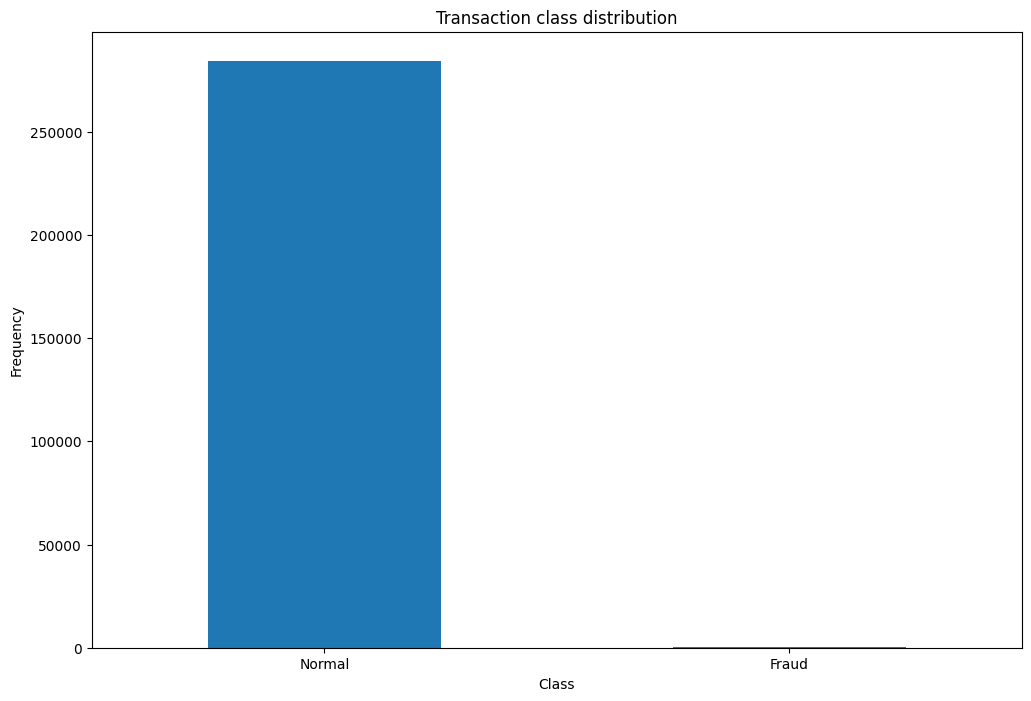

In [52]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [53]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
print('frauds=',frauds.shape)
print('normal=', normal.shape)

frauds= (492, 31)
normal= (284315, 31)


In [54]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [55]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

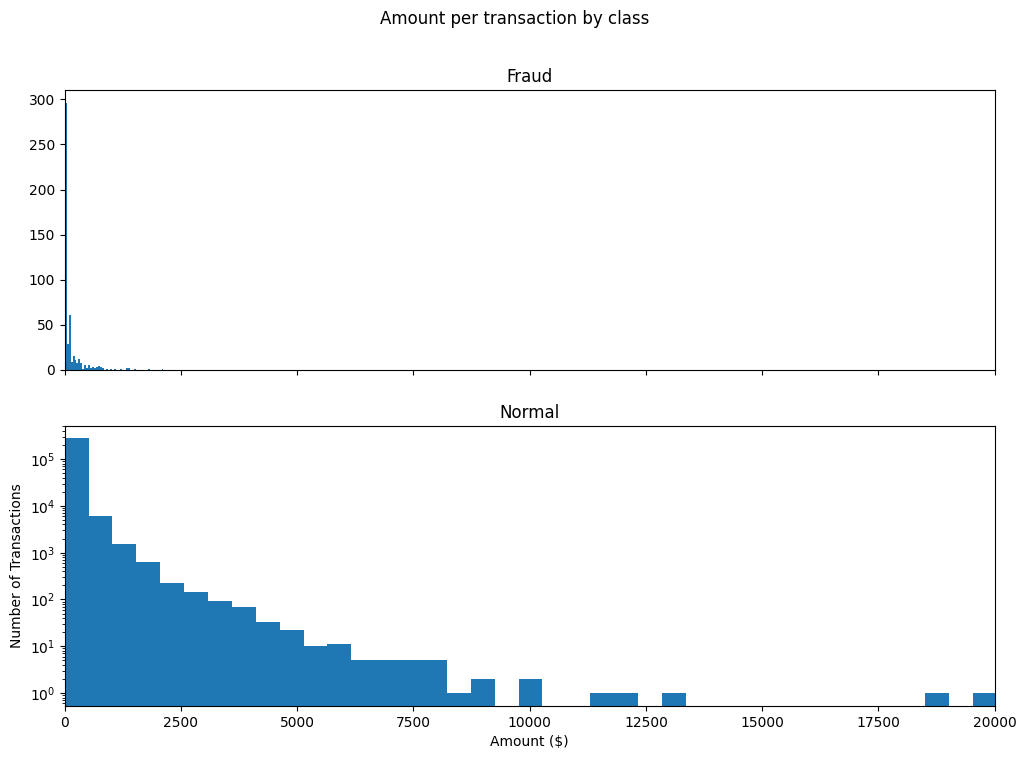

In [56]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

Do fraudulent transactions occur more often during certain time?

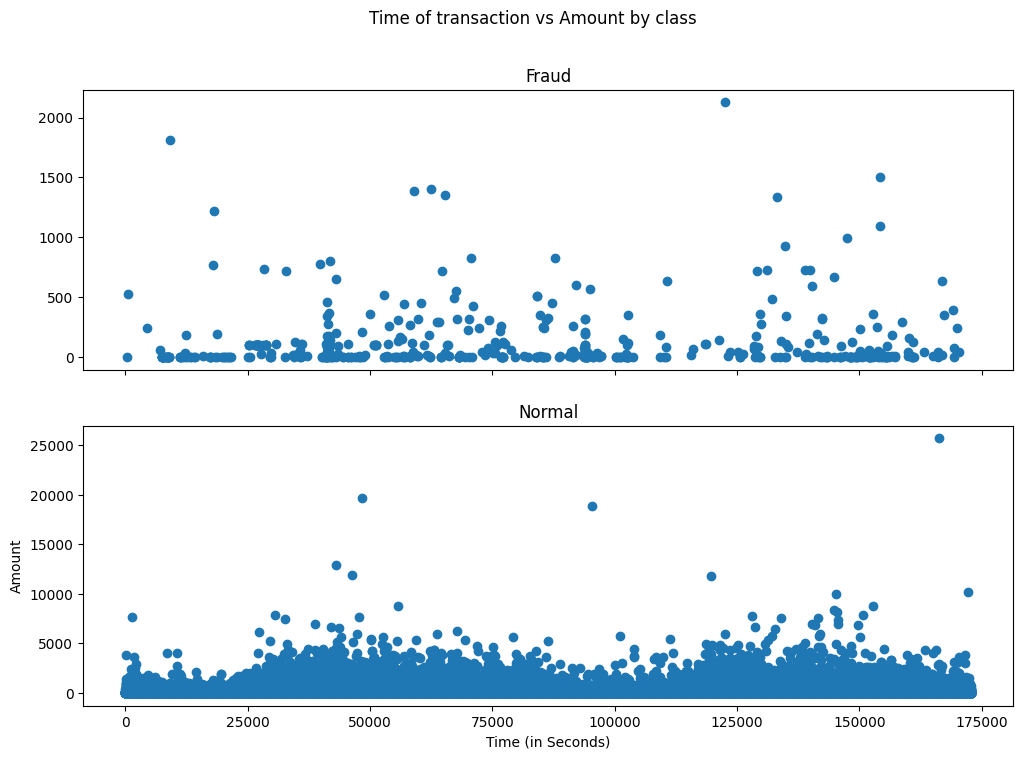

In [57]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

Doesn't seem like the time of transaction really matters.

## Training the Model

In [58]:
from sklearn.preprocessing import StandardScaler
data = df.drop(['Time'], axis=1) #drop time column because it doesn't have important effect

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [59]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state= 42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [60]:
input_layer = Input(shape=(X_train.shape[1], ))
encoding_dim = 14
encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(X_train.shape[1], activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [61]:
nb_epoch = 10
batch_size = 32

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/10
7108/7108 [==============================] - 24s 3ms/step - loss: 0.8101 - accuracy: 0.5898 - val_loss: 0.7793 - val_accuracy: 0.6555
Epoch 2/10
7108/7108 [==============================] - 17s 2ms/step - loss: 0.7348 - accuracy: 0.6748 - val_loss: 0.7557 - val_accuracy: 0.6831
Epoch 3/10
7108/7108 [==============================] - 17s 2ms/step - loss: 0.7221 - accuracy: 0.6909 - val_loss: 0.7484 - val_accuracy: 0.6913
Epoch 4/10
7108/7108 [==============================] - 20s 3ms/step - loss: 0.7166 - accuracy: 0.6962 - val_loss: 0.7451 - val_accuracy: 0.6969
Epoch 5/10
7108/7108 [==============================] - 17s 2ms/step - loss: 0.7135 - accuracy: 0.6969 - val_loss: 0.7429 - val_accuracy: 0.7006
Epoch 6/10
7108/7108 [==============================] - 17s 2ms/step - loss: 0.7114 - accuracy: 0.6966 - val_loss: 0.7425 - val_accuracy: 0.6938
Epoch 7/10
7108/7108 [==============================] - 18s 3ms/step - loss: 0.7102 - accuracy: 0.6936 - val_loss: 0.7411 - val_ac

## Evaluation

In [67]:
predictions = autoencoder.predict(X_test)

1781/1781 [==============================] - 2s 1ms/step


In [68]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

## Prediction

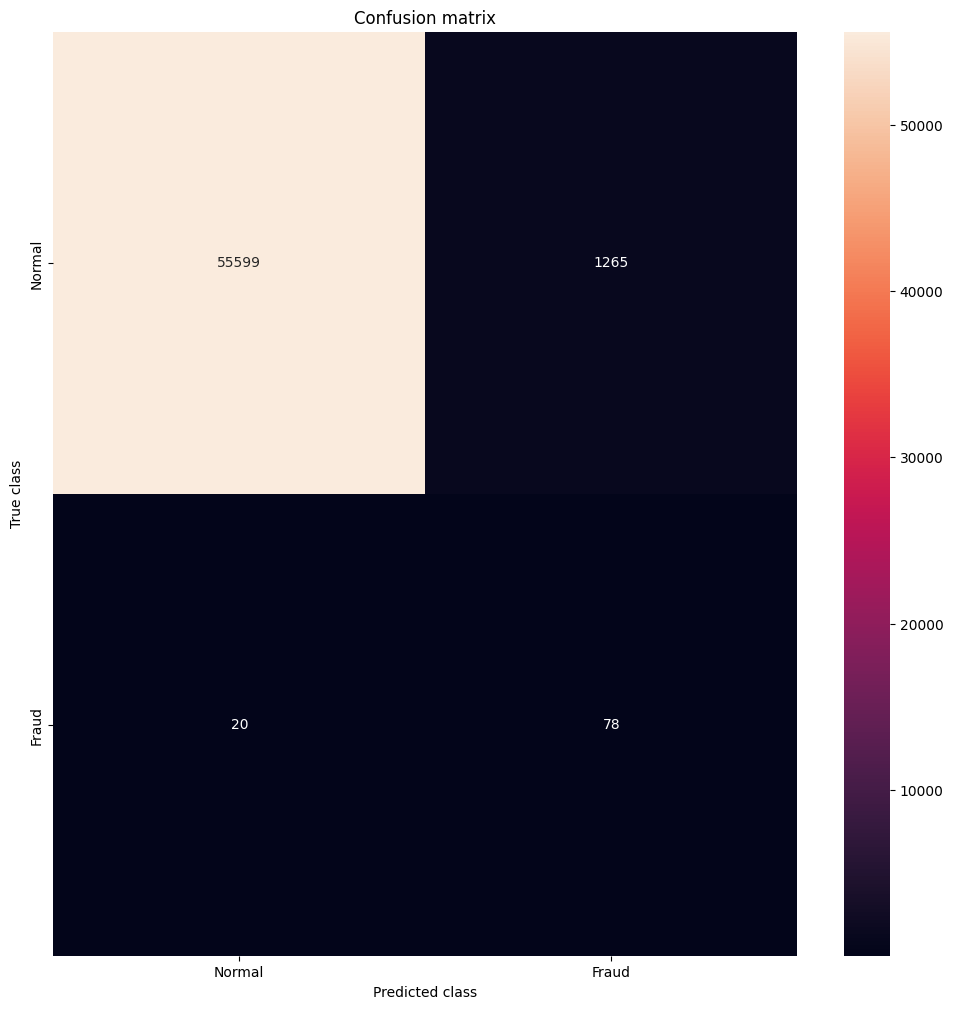

In [69]:
y_pred = [1 if e > 2.9 else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [70]:
from sklearn.metrics import precision_score, recall_score

# Calculate precision
precision = precision_score(error_df.true_class, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.058078927773641105
Recall: 0.7959183673469388


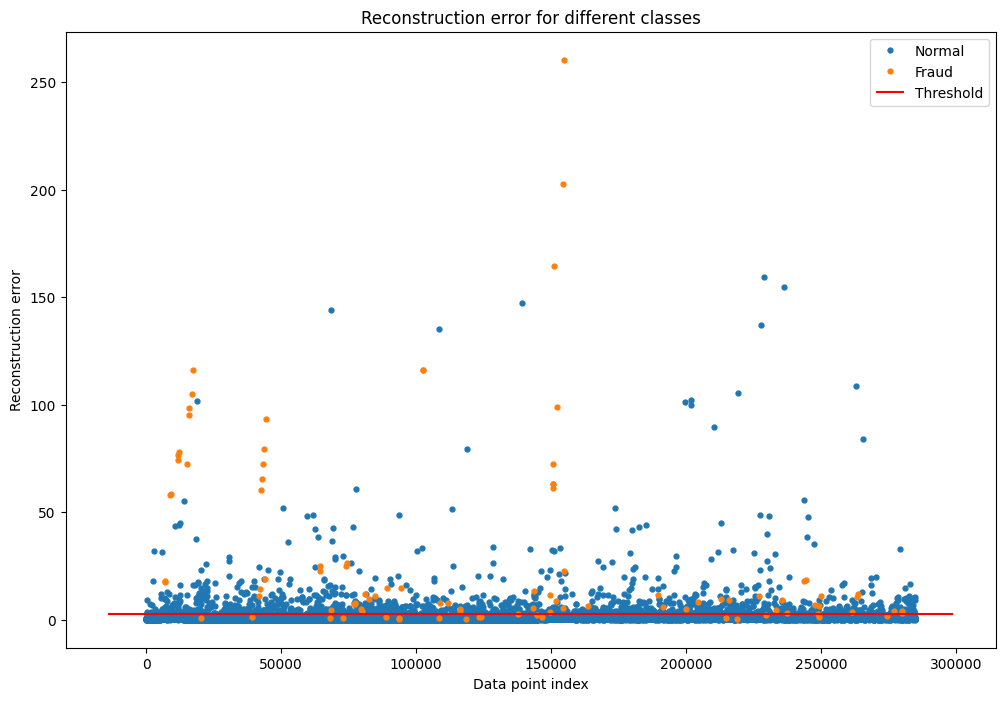

In [71]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(2.9, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()